In [1]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
import numpy as np
from scipy.sparse import csr_matrix
from scipy import cluster
import scipy.io
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import confusion_matrix
import copy
from scipy.cluster.hierarchy import dendrogram
from scipy import sparse
import pandas as pd
import pickle

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

import yfinance as yf

import csv

plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True

sns.set_theme(style="ticks")

In [2]:
yf.__version__ ## needs to be >= 0.2.3, see this https://github.com/ranaroussi/yfinance/issues/1246

'0.2.3'

In [3]:
data_dir = "../stock/"

In [25]:
# file = open(data_dir+'nasdaqtraded.txt','r')

# lines = file.readlines()

# for line in lines[1:-1]:
#     words = line.split('|')
#     #print(words[0])
#     if(words[2].find('Common Stock') != -1 and words[2].find('Warrant') == -1 and words[1].find('$') == -1):
#         print(words[1],words[2])
#         companies.append(words[1].replace('.','-'))
    

# file.close()
company_names = pd.read_csv(data_dir+'nasdaqtraded.txt', sep = "|")

In [26]:
company_names

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAA,Listed Funds Trust AAF First Priority CLO Bond...,P,,Y,100.0,N,NaN,AAA,AAA,N
3,Y,AAAU,Goldman Sachs Physical Gold ETF Shares,P,,Y,100.0,N,NaN,AAAU,AAAU,N
4,Y,AAC,Ares Acquisition Corporation Class A Ordinary ...,N,,N,100.0,N,NaN,AAC,AAC,N
...,...,...,...,...,...,...,...,...,...,...,...,...
10851,Y,ZY,Zymergen Inc. - Common Stock,Q,Q,N,100.0,N,N,NaN,ZY,N
10852,Y,ZYME,Zymeworks Inc. Common Shares,N,,N,100.0,N,NaN,ZYME,ZYME,N
10853,Y,ZYNE,"Zynerba Pharmaceuticals, Inc. - Common Stock",Q,G,N,100.0,N,N,NaN,ZYNE,N
10854,Y,ZYXI,"Zynex, Inc. - Common Stock",Q,S,N,100.0,N,N,NaN,ZYXI,N


In [4]:
"""
companies is the name of companies
"""
ICB_codes = pickle.load(open(data_dir+"ICB_codes.pickle", 'rb'))
yahoo_codes = pickle.load(open(data_dir+"yahoo_codes.pickle", 'rb'))

def getICBtruth(companies, codetype = "Supersector Code"):
   
    truth = []

    for c in companies:
        code = ICB_codes[codetype].get(c, -1)
        s = int(code)
        truth.append(s)
    return np.array(truth)

def getYahootruth(companies):
   
    truth = []

    for c in companies:
        code = yahoo_codes.get(c, -1)
#         s = int(code)
        truth.append(code)
    return np.array(truth)

In [5]:
ICB_codes.keys()

dict_keys(['Supersector Code', 'Industry Code', 'Sector Code', 'Subsector Code'])

In [6]:
companies = pd.read_csv(data_dir+"stockdata1319/components.csv", header=None)[0].to_numpy()

In [7]:
len(companies)

2440

In [8]:
# supersector_dict = {1010: 0,
#  1510: 1,
#  2010: 2,
#  3010: 3,
#  3020: 4,
#  3030: 5,
#  3510: 6,
#  4010: 7,
#  4020: 8,
#  4030: 9,
#  4040: 10,
#  4050: 11,
#  4510: 12,
#  4520: 13,
#  5010: 14,
#  5020: 15,
#  5510: 16,
#  5520: 17,
#  6010: 18,
#  6510: 19}
# j = 0
# for i in np.unique(true_labels):
#     supersector_dict[i] = j
#     j=j+1

In [9]:
supersector_dict = {1010: "TECHNOLOGY",
 1510: "TELECOMMUNICATIONS",
 2010: "HEALTH CARE",
 3010: "BANKS",
 3020: "FINANCIAL SERVICES",
 3030: "INSURANCE",
 3510: "REAL ESTATE",
 4010: "AUTOMOBILES & PARTS",
 4020: "CONSUMER PRODUCTS & SERVICES",
 4030: "MEDIA",
 4040: "RETAIL",
 4050: "TRAVEL & LEISURE",
 4510: "FOOD & BEVERAGE",
 4520: "PERSONAL CARE DRUG AND GROCERY STORES",
 5010: "CONSTRUCTION & MATERIALS",
 5020: "INDUSTRIAL GOODS & SERVICES",
 5510: "BASIC RESOURCES",
 5520: "CHEMICALS",
 6010: "ENERGY",
 6510: "UTILITIES"}

In [10]:
industry_dict = {
    10:"TECHNOLOGY",
    15:"TELECOMMUNICATIONS",
    20:"HEALTH CARE",
    30:"FINANCIALS",
    35:"REAL ESTATE",
    40:"CONSUMER DISCRETIONARY",
    45:"CONSUMER STAPLES",
    50:"INDUSTRIALS",
    55:"BASIC MATERIALS",
    60:"ENERGY",
    65:"UTILITIES"
}

In [11]:
level = "Industry Code"
k = len(np.unique(list(ICB_codes[level].values())))
true_labels = getICBtruth(companies, level)
valid_sector = np.where((true_labels != -1))[0].astype(int)
# valid_sector = np.where((true_labels != '') & (true_labels != "None"))[0]
true_labels = true_labels[valid_sector]
true_companies = companies[valid_sector]
Z = np.genfromtxt(data_dir+"/Zs/stock%semb-prefix-Z-%s-0" %("1319", 30))
tmfg_clustering = scipy.cluster.hierarchy.cut_tree(Z, n_clusters=[11]).flatten().astype(str)

In [12]:
companies_true = companies[valid_sector]

In [33]:
true_labels_txt = [industry_dict[int(t)] for t in true_labels]

In [98]:
np.unique(tmfg_clustering)

array(['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype='<U21')

In [14]:
tmfg_clustering

array(['0', '1', '2', ..., '0', '4', '7'], dtype='<U21')

In [15]:
len(tmfg_clustering)

1614

In [46]:
market_caps = {}
getMarketCap(companies_true,market_caps)
# pickle.dump(market_caps, open("../stock/market_caps.pkl", "wb"))
market_cap_df = pd.DataFrame.from_dict(market_caps, orient='index', columns =["market_cap"])

AAPL , 2042361282560
AAWW , 2860104192
ABCB , 3270626048
ABEO , 48779272
ABG , 3937699840
ABMD , 17180649472
ACAD , 2566606592
ACGL , 23213228032
ACHC , 7440529920
ACIW , 2594153728
ACLS , 2580585984
ACM , 11746427904
ACRE , 549325824
ACRX , 17059058
ADBE , 155338194944
ADC , 6327611392
ADES , 43955068
ADM , 50824380416
ADSK , 39876550656
ADUS , 1599279360
AEE , 23225616384
AEL , 3947019520
AGEN , 699543552
AGM , 1189351680
AGO , 3713659648
AGYS , 1981849984
AIN , 3064593920
AIT , 4859879424
AIV , 1083410688
AIZ , 6651473408
AJRD , 4514775552
AKAM , 13254714368
ALB , 25500692480
ALBO , 444951680
ALGN , 16466874368
ALNY , 28974940160
AMCX , 661462208
AMD , 103529627648
AMED , 2730302720
AMEH , 1351855744
AMG , 5987423744
AMOT , 550263808
AMRC , 2939122432
AMRS , 519998880
AMSC , 102338952
AMSWA , 494802976
AMWD , 819288512
AMZN , 845976043520
AN , 9476575232
ANGO , 533430400
ANIK , 425142272
ANIP , 724681792
ANSS , 20926963712
APEI , 238890608
APPS , 1491866368
APT , 49058800
ARAY , 190

DORM , 2582083328
DOV , 19453812736
DPZ , 12603206656
DRH , 1708128128
DRI , 18066071552
DRQ , 951526848
DRRX , 784895680
- DSPG: No summary info found, symbol may be delisted
DSPG , -1
DTE , 22997331968
DUK , 79450046464
DVA , 7653199872
DVAX , 1253498368
DVN , 41540243456
DX , 471338848
DXC , 6671721984
DXCM , 10740411392
DXPE , 514891456
DY , 2821292032
DYAI , 34543032
DZSI , 355736128
EA , 34372485120
EAT , 1493100288
EBAY , 25841442816
EBF , 579113664
EBIX , 629852864
EBMT , 108852856
EBS , 624602880
- EBSB: No summary info found, symbol may be delisted
EBSB , -1
EBTC , 430333216
- ECHO: No summary info found, symbol may be delisted
ECHO , -1
ECL , 41921884160
ECOL , 1512275328
ECPG , 1416164864
ED , 34021810176
EEFT , 5036119552
EFC , 712964864
EFSC , 1908019200
EFX , 23760500736
EGAN , 280768320
EGBN , 1427534976
EGHT , 496009952
EGLE , 674929088
EGP , 6025853440
EHC , 5922788352
EHTH , 125343472
EIG , 1212816000
EIX , 24348301312
EL , 88802525184
ELMD , 87838808
ELOX , 15525432

JBHT , 18437308416
JBL , 9829237760
JBLU , 2060840960
JBSS , 928972160
JBT , 2910910976
- JCOM: No summary info found, symbol may be delisted
JCOM , -1
JEF , 8395729920
JJSF , 2874773504
JKHY , 12997156864
JLL , 8065354752
JNJ , 463837822976
JNPR , 10370021376
JOE , 2286707712
JOUT , 675788096
JPM , 405858123776
JWN , 2572108288
K , 24223145984
KAI , 2081775488
KALU , 1215817344
KAMN , 611381504
KAR , 1574396160
KBAL , 235129712
KBH , 2771290368
KBR , 7343919104
KDP , 50539638784
KELYA , 671719040
KEX , 3839890688
KEY , 16279548928
KFRC , 1172540928
KFY , 2759888384
KIM , 13025123328
KKR , 27144419328
KLAC , 56868864000
KMB , 45719433216
KMI , 40904437760
KMT , 2016680960
KO , 274434342912
KOP , 604033600
KR , 32847560704
- KRA: No summary info found, symbol may be delisted
KRA , -1
KRC , 4491065856
KRG , 4602536960
KRMD , 153736144
KRNY , 766260480
KRO , 1095413888
KSS , 3502606848
- KSU: No summary info found, symbol may be delisted
KSU , -1
KTOS , 1240480000
KVHI , 188802000
KW , 21

PLAB , 1028304960
PLBC , 213937536
PLCE , 517890144
PLD , 83584614400
PLOW , 838576704
PLPC , 402552128
PLUG , 7042954752
PLUS , 1183340160
PLXS , 2873504768
PM , 156476981248
PNC , 66699087872
PNFP , 5579656192
PNM , 4200759808
PNRG , 171509440
PODD , 19836372992
POOL , 12100562944
POR , 4423987200
POST , 5630732800
POWI , 4313716736
POWL , 413278048
PPBI , 2970298624
PPC , 5725167616
PPG , 29637138432
PPL , 21984718848
PRA , 938774784
PRAA , 1488075520
PRDO , 987786560
PRFT , 2288395264
PRGS , 2211415552
PRI , 5597653504
PRIM , 1178137216
PRK , 2277556224
PRMW , 2496744192
PRO , 1072957056
PROV , 101358216
PRTK , 90405272
PRTS , 306883968
PRU , 37642678272
PSA , 49123954688
- PSB: No summary info found, symbol may be delisted
PSB , -1
PSMT , 1893723008
PSX , 45564243968
PTC , 14031482880
PTEN , 3608503808
PTRS , 161065632
PTSI , 291745728
PVH , 4892484096
PWFL , 94916184
PWOD , 188756192
PWR , 20166459392
PXD , 55430627328
PXLW , 92621176
PZN , 696454976
PZZA , 3009476352
- QADA: No 

In [34]:
d = {'companies': true_companies, 'clustering': tmfg_clustering, "sector": true_labels_txt}
market_caps = pickle.load(open(data_dir+"market_caps.pkl", 'rb'))
outputs = pd.DataFrame(data=d)
outputs_names = outputs.set_index('companies').join(company_names[["Symbol", "Security Name"]].set_index("Symbol"))
# add market cap
outputs_names_cap = outputs_names.join(market_cap_df)
# outputs_names_cap.to_csv("stock_results.csv")
# add supersector code
outputs_2 = outputs_names_cap.join(pd.DataFrame.from_dict(ICB_codes['Supersector Code'], orient='index', columns =['Supersector Code']))
# add sector code
outputs_3 = outputs_2.join(pd.DataFrame.from_dict(ICB_codes['Sector Code'], orient='index', columns =['Sector Code']))
# add subsector code
outputs_4 = outputs_3.join(pd.DataFrame.from_dict(ICB_codes['Subsector Code'], orient='index', columns =['Subsector Code']))
outputs_4.to_csv("stock_results.csv")

<AxesSubplot:ylabel='Sector Code'>

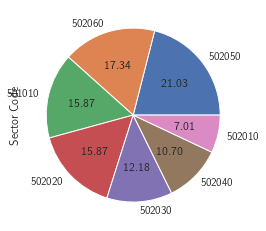

In [196]:
outputs_4[(outputs_4["sector"]=="INDUSTRIALS")]["Sector Code"].value_counts().plot(kind='pie', 
                                                                                            autopct='%.2f')

<AxesSubplot:ylabel='Sector Code'>

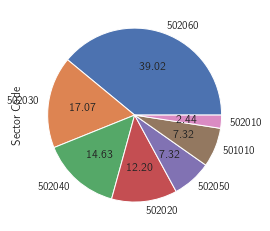

In [197]:
outputs_4[(outputs_4["clustering"]=="1") 
          & (outputs_4["sector"]=="INDUSTRIALS")]["Sector Code"].value_counts().plot(kind='pie', 
                                                                                            autopct='%.2f')

<AxesSubplot:ylabel='Sector Code'>

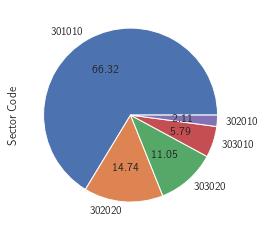

In [211]:
outputs_4[(outputs_4["clustering"]=="2") 
          & (outputs_4["sector"]=="FINANCIALS")]["Sector Code"].value_counts().plot(kind='pie',
                                                                                        autopct='%.2f')

<AxesSubplot:ylabel='Sector Code'>

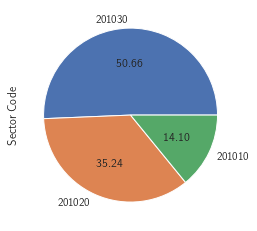

In [180]:
outputs_3[(outputs_3["sector"]=="HEALTH CARE")]["Sector Code"].value_counts().plot(kind='pie',
                                                                                        autopct='%.2f')

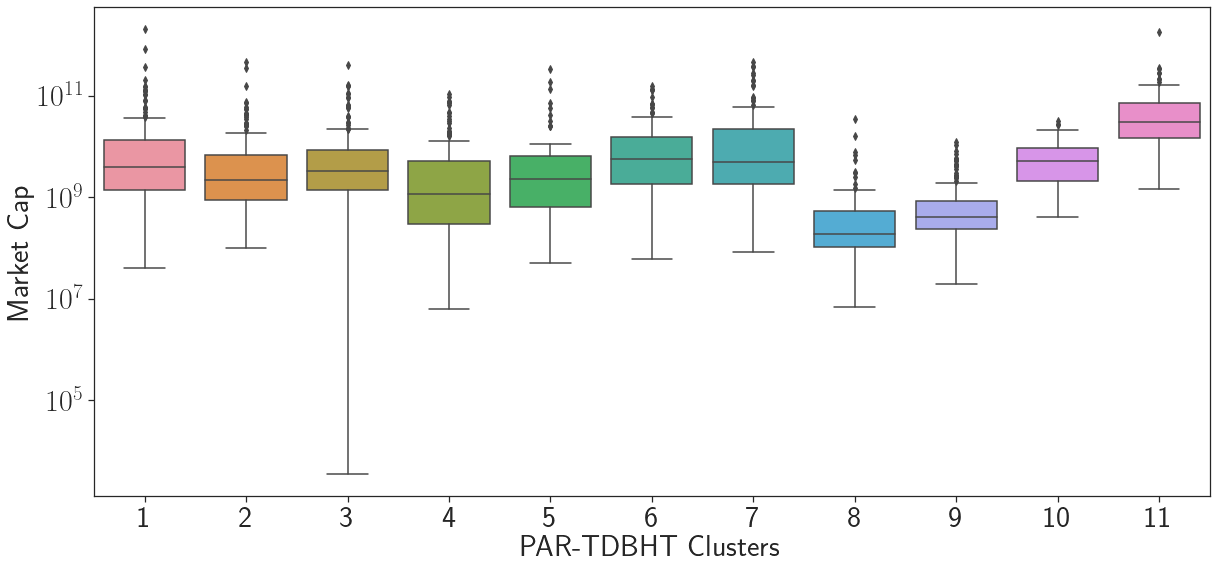

In [152]:
f, ax = plt.subplots(figsize=(20, 9))
sns.boxplot(
    x = "clustering",
    y = "market_cap",
    whis = 2,
    data = outputs_names_cap[outputs_names_cap["market_cap"]>0],
    ax = ax
)
plt.yscale("log")
ax.set_xlabel("PAR-TDBHT Clusters", fontsize = 30)
ax.set_ylabel("Market Cap", fontsize = 30)

ax.set_xticklabels(list(range(1,12)))

for l in ax.yaxis.get_ticklabels():
    l.set_fontsize(30)
for l in ax.xaxis.get_ticklabels():
    l.set_fontsize(30)
    
f.savefig("./figures/dbht_market_cap.pdf")

In [201]:
10**-9 * np.median(outputs_names_cap[(outputs_names_cap["clustering"]=="10") ]["market_cap"])

28.778627072000003

In [209]:
10**-9 * outputs_4[(outputs_4["sector"]=="INDUSTRIALS")]["market_cap"].median()

2.7711165440000003

In [145]:
def get_firt_letter(line):
    if line[0:2] == "TE":
        return line[0:3]
    words = line.split()
    letters = [word[0] for word in words]
    return "".join(letters)

In [146]:
get_firt_letter(l.get_text())

'TE'

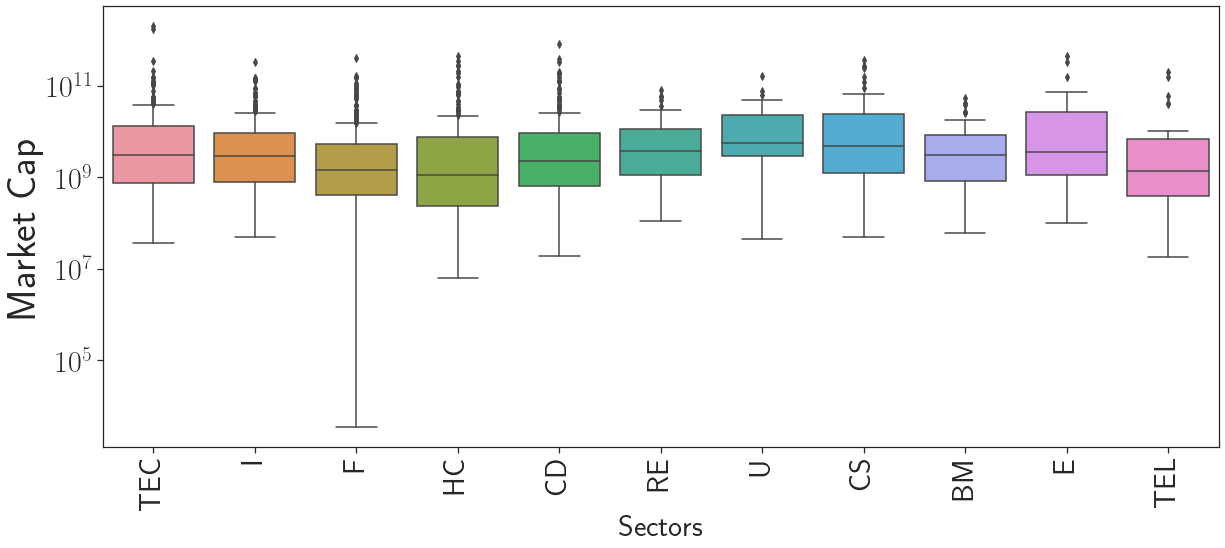

In [150]:
f, ax = plt.subplots(figsize=(20, 9))
sns.boxplot(
    x = "sector",
    y = "market_cap",
    whis = 2,
    data = outputs_names_cap[outputs_names_cap["market_cap"]>0]
)
plt.yscale("log")
plt.xticks(rotation = 90);
ax.set_xlabel("Sectors", fontsize = 30)
ax.set_ylabel("Market Cap", fontsize = 40)

for l in ax.yaxis.get_ticklabels():
    l.set_fontsize(30)
    
x_labels = [get_firt_letter(l.get_text()) for l in ax.xaxis.get_ticklabels()]
ax.set_xticklabels(x_labels)
for l in ax.xaxis.get_ticklabels():
    l.set_fontsize(30)
    

f.subplots_adjust(bottom=0.2)
f.savefig("./figures/sector_market_cap.pdf")

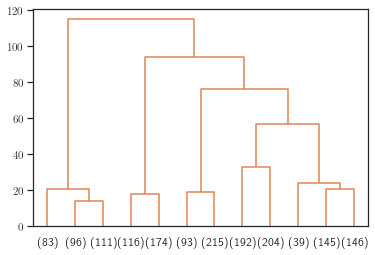

In [116]:
dendrogram(Z, p = 12, truncate_mode="lastp", leaf_rotation=0, color_threshold=240, above_threshold_color='grey');

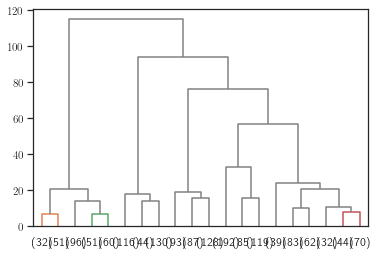

In [120]:
dendrogram(Z, p = 20, truncate_mode="lastp", leaf_rotation=0, color_threshold=10, above_threshold_color='grey');

In [114]:
+ 96 + 111 291
[207, 145,  146, ]

1614

In [109]:
[np.sum(tmfg_clustering==str(i)) for i in range(11)]

[207, 145, 192, 174, 93, 146, 215, 116, 204, 39, 83]

1614
0.3612377104679966


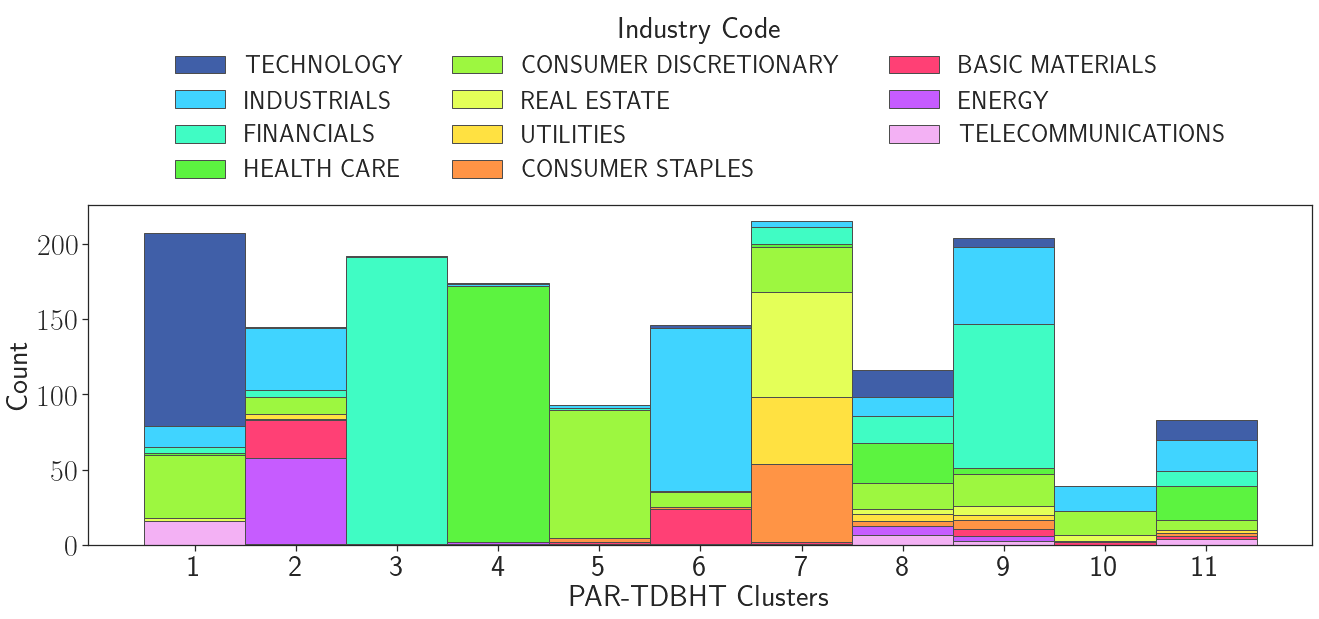

In [40]:
f = plot("Industry Code", 1319, 30)##emb
# plt.tight_layout()
f.subplots_adjust(left = 0.1, right = 0.95, top=0.65)
f.savefig("../figures/stock.pdf")

1614
0.3704995327214337


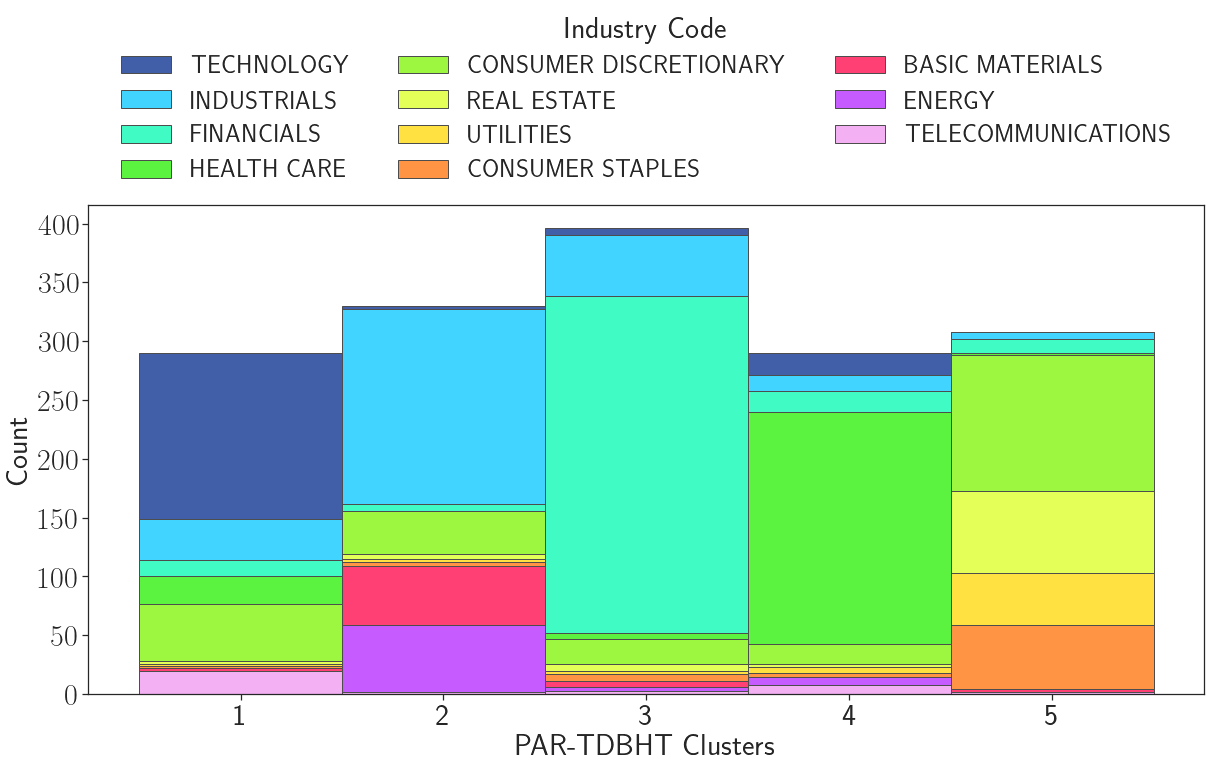

In [118]:
flags = tmfg_clustering=='6'
f = plot("Industry Code", 1319, prefix=30, emb = True, tmfg_k = 5)

1614
0.16254635256011235


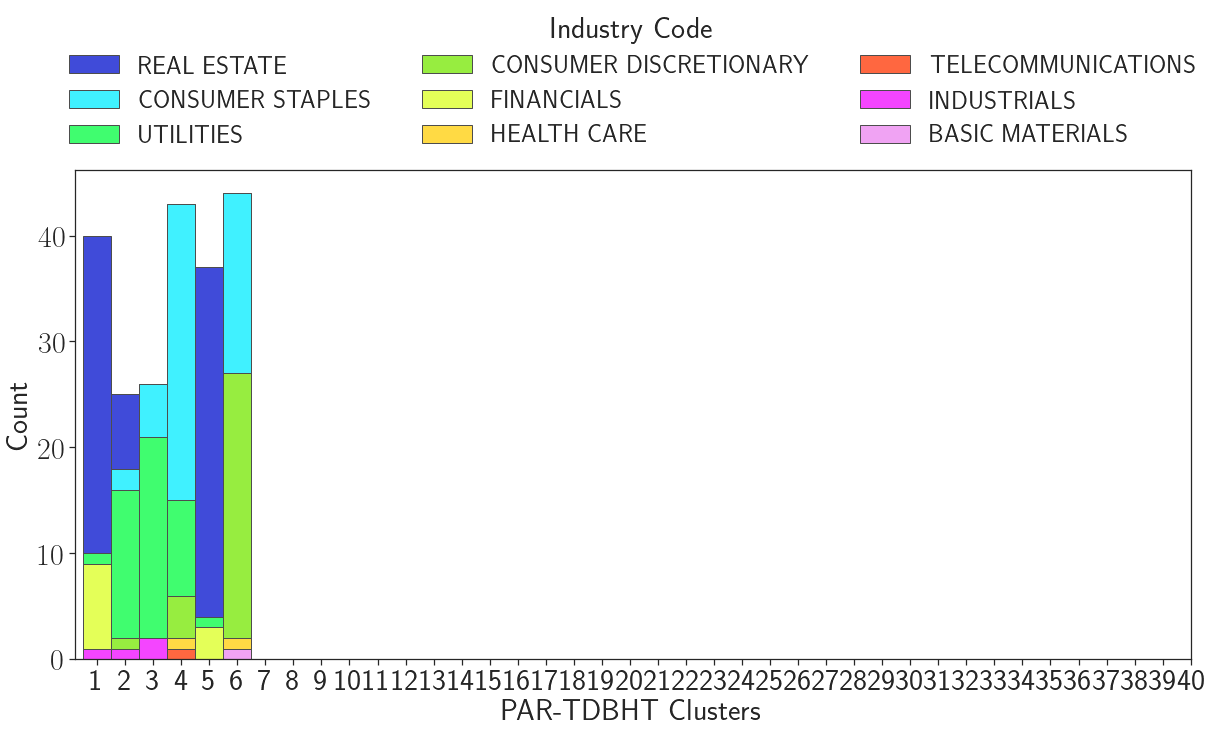

In [105]:
f = plot("Industry Code", 1319, prefix=30, emb = True, tmfg_k = 40, flags = flags)

In [39]:
ticker = yf.Ticker("TSLA")

In [40]:
ticker.info

{'zip': '78725',
 'sector': 'Consumer Cyclical',
 'fullTimeEmployees': 99290,
 'longBusinessSummary': 'Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits. It provides sedans and sport utility vehicles through direct and used vehicle sales, a network of Tesla Superchargers, and in-app upgrades; and purchase financing and leasing services. This segment is also involved in the provision of non-warranty after-sales vehicle services, sale of used vehicles, retail merchandise, and vehicle insurance, as well as sale of products to third party customers; services for electric vehicles through its company-owned service locations, and Tesla mobile service technicians; and vehicle limited warrantie

In [43]:
def printNames(companies):
    for company in companies:
        ticker = yf.Ticker(company)
        try:
            print(ticker.info['shortName'])
        except:
            print("failed for", company)

            
def getTMFGCluster(i):
    return companies_true[np.where(tmfg_clustering==str(i))]

def getMarketCap(companies, market_caps):
    for company in companies:
        ticker = yf.Ticker(company)
        try:
            market_caps[company] = ticker.info['marketCap']
            print(company, "," , ticker.info['marketCap'])
        except:
            market_caps[company] = -1
            print(company, "," , -1)


In [92]:
def plot(level, years, prefix=1, emb = True, tmfg_k=0, flags = None):
    k = len(np.unique(list(ICB_codes[level].values())))
    true_labels = getICBtruth(companies, level)
    valid_sector = np.where((true_labels != -1))[0].astype(int)
    # valid_sector = np.where((true_labels != '') & (true_labels != "None"))[0]
    true_labels = true_labels[valid_sector]
    true_companies = companies[valid_sector]
    print(len(true_labels))
#     with open('stock_names.csv', 'w') as csv_file:
#         writer = csv.writer(csv_file)
#         for key, value in enumerate(true_companies):
#             writer.writerow([key, value])
    
    Z = []
    if emb:
        if prefix==1:
            Z = np.genfromtxt(data_dir + "/Zs/stock%semb-exact-Z-0" % years)
        else:
            Z = np.genfromtxt(data_dir + "Zs/stock%semb-prefix-Z-%s-0" %(years, prefix))
    else:
        if prefix==1:
            Z = np.genfromtxt(data_dir + "Zs/stockicb%s-exact-Z-0" % years)
        else:
            Z = np.genfromtxt(data_dir + "Zs/stockicb%s-prefix-Z-%s-0" %(years, prefix))
    
    if tmfg_k==0:
        tmfg_k = k
    tmfg_clustering = scipy.cluster.hierarchy.cut_tree(Z, n_clusters=[tmfg_k]).flatten().astype(str)
    
    print(adjusted_rand_score(tmfg_clustering, true_labels))
    
    if flags is not None:
        tmfg_clustering = tmfg_clustering[flags]
        true_labels = true_labels[flags]
    
#     tmfg_clustering = tmfg_clustering[valid_sector]
    
    
    stockdf = pd.DataFrame(np.array([np.array(true_labels), 
                             tmfg_clustering]).transpose()
                        , columns = ['true','tmfg'])
    f, ax = plt.subplots(figsize=(20, 9))

    g = sns.histplot(
        stockdf,
        x="tmfg", hue="true",
        multiple="stack",
        palette="gist_ncar",#"gist_rainbow",
        edgecolor=".3",
#         bins=k,binwidth=1
        ax = ax,
        )
        
#     hatches = ['+', '\\', '/',  '*', '-', 'x', '.', 'o', 'O', '|', '|', '|', '|', '|']

#     # Loop over the bars
#     for i,thisbar in enumerate(ax.patches):
#         if(i < 10):
#             thisbar.set_hatch(hatches[i])
        
    ax.set_xticks(np.array(list(range(tmfg_k))));
    ax.set_xticklabels(np.array(list(range(tmfg_k)))+1);
#     ax.set_xlim(-1,)
    ax.set_xlabel("PAR-TDBHT Clusters", fontsize = 30)
    ax.set_ylabel("Count", fontsize = 30)
    
    for l in ax.yaxis.get_ticklabels():
        l.set_fontsize(30)
    for l in ax.xaxis.get_ticklabels():
        l.set_fontsize(30)
    # plt.legend(bbox_to_anchor=([1, 1]), fontsize = 15)#title='supersectors', 
    if level=="Supersector Code":
        for t in g.legend_.texts:
            t.set_text(supersector_dict[int(t.get_text())])
    if level=="Industry Code":
        for t in g.legend_.texts:
            t.set_text(industry_dict[int(t.get_text())])
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, fontsize = 25, title_fontsize=30, frameon=False, title=level)
    return f

1614
0.2784735506378764


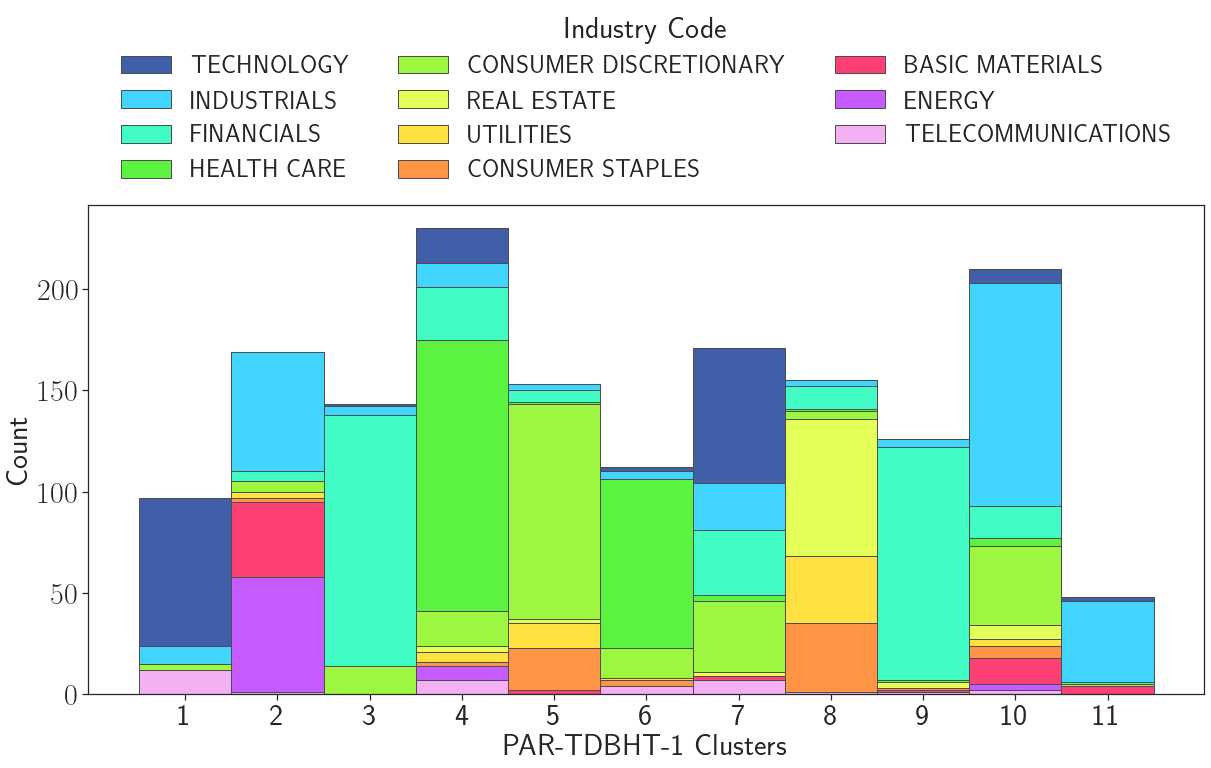

In [38]:
plot("Industry Code", 1319, 1)
f.subplots_adjust(left = 0.1, right = 0.95, top=0.65)
f.savefig("../figures/stock-1.pdf")

1614


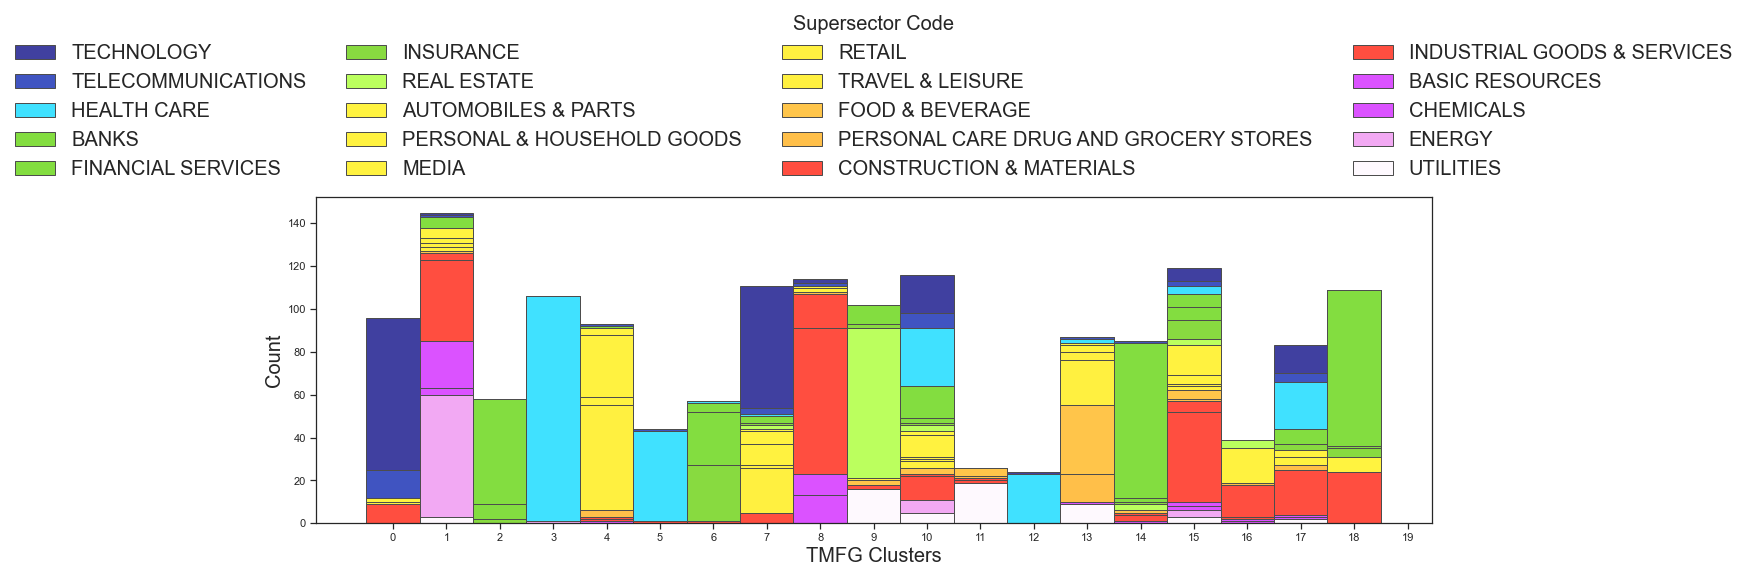

In [143]:
ax = plot("Supersector Code", 1319, 30,True)##emb

1614


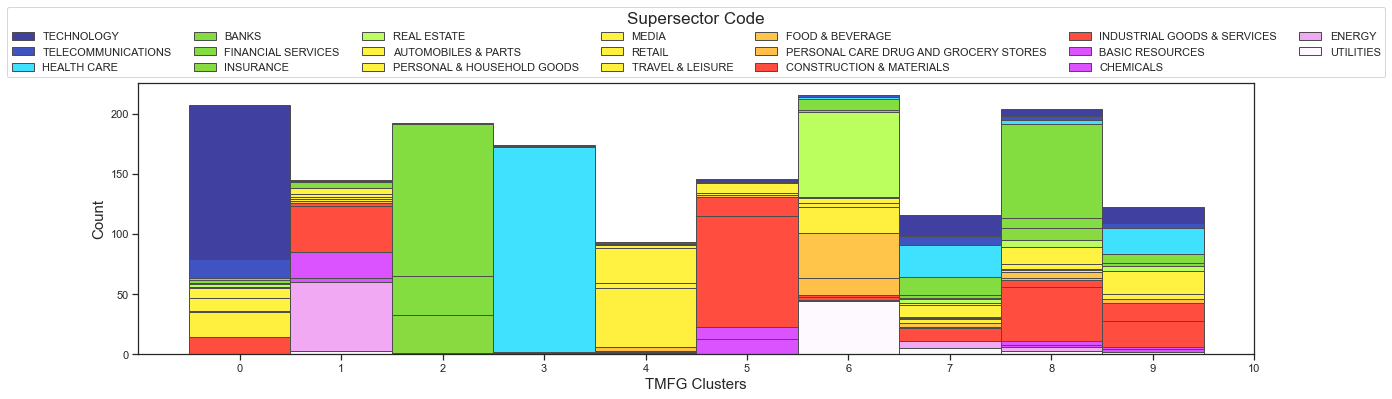

In [118]:
ax = plot("Supersector Code", 1319, 30,True,11)##emb

1614


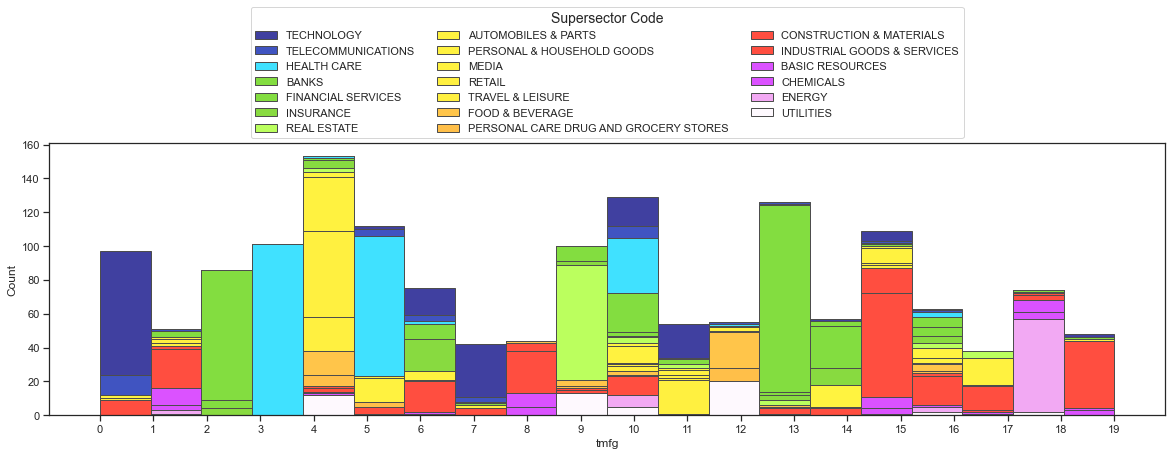

In [54]:
plot("Supersector Code", 1319) ##emb

1614


<AxesSubplot:xlabel='TMFG Clusters', ylabel='Count'>

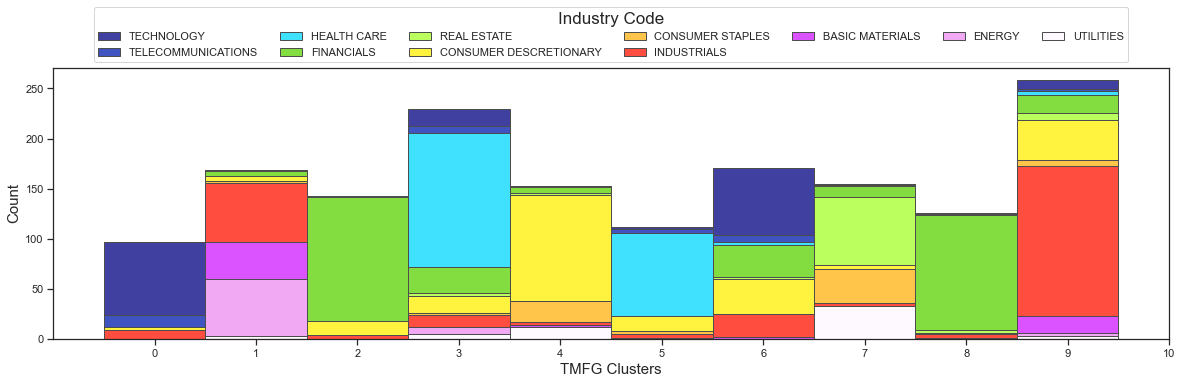

In [119]:
plot("Industry Code", 1319) ##emb

1614


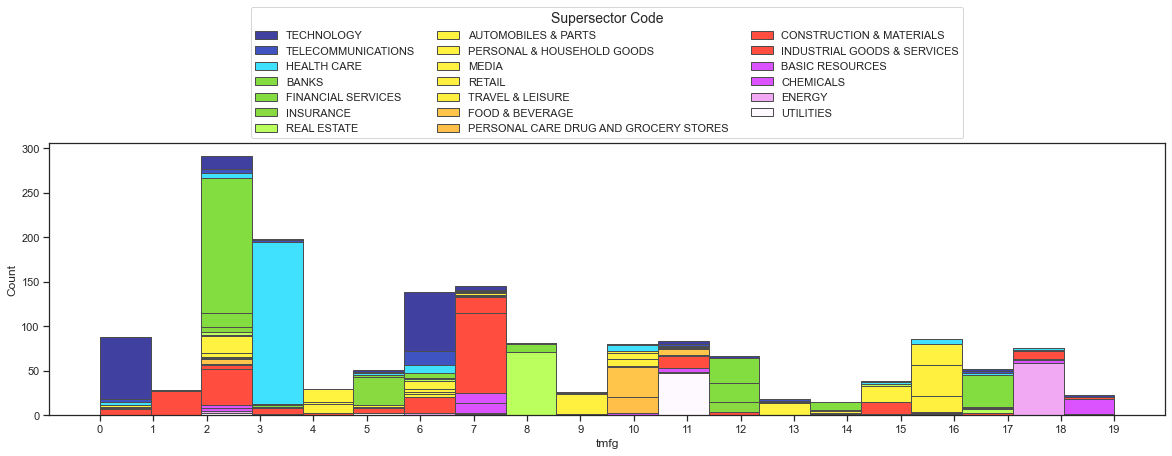

In [50]:
plot("Supersector Code", 1319)

1614


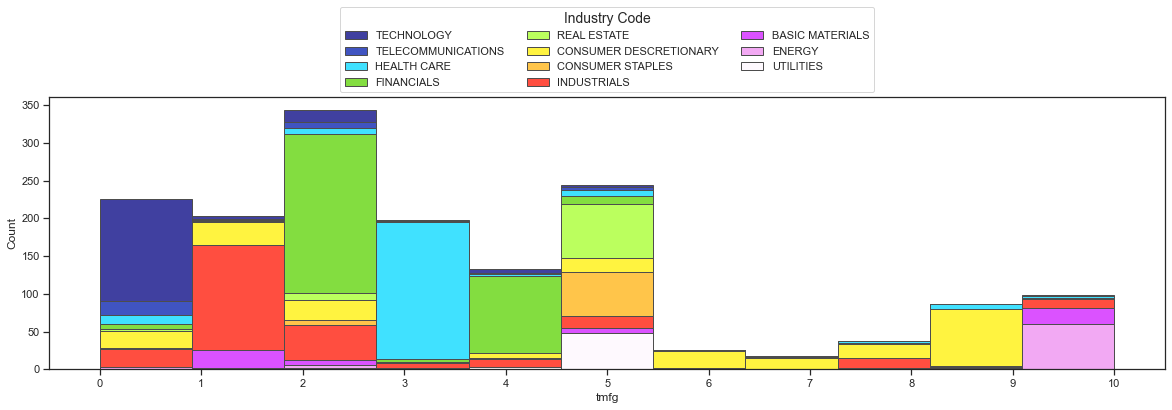

In [51]:
plot("Industry Code", 1319)

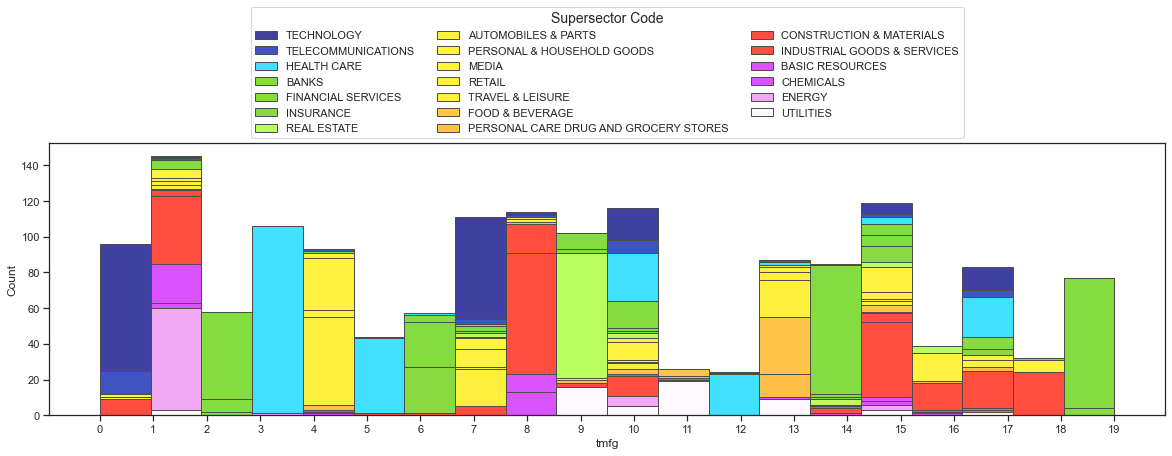

In [42]:
plot("Supersector Code", 1319, 30)

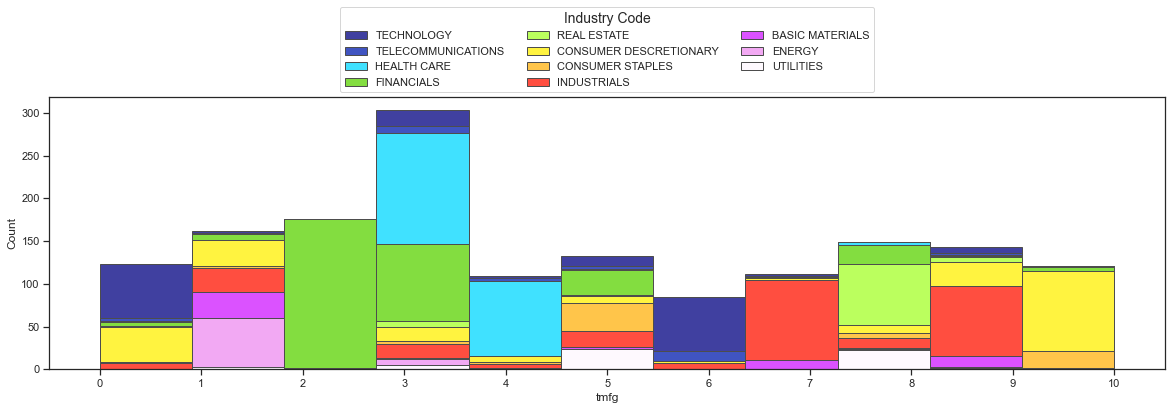

In [41]:
plot("Industry Code", 1319, 10)

In [46]:
for i in [1,2,3,4]:
    for j in [1,2,3,4]:
        if(j > i):
            print("(v_%s, v_%s)" % (i,j))

(v_1, v_2)
(v_1, v_3)
(v_1, v_4)
(v_2, v_3)
(v_2, v_4)
(v_3, v_4)
